In [1]:
#import modules
import rasterio
import os
from matplotlib import pyplot as plt
import xarray as xr

In [2]:
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import datacube_stats

# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

In [3]:
# set working folder
os.chdir('/g/data/u46/users/ck9738/')

In [4]:
#trees = load_gfif("woody_files/s5hgps_nsw_y20082012_bcvl0.tif", Window=((25000,60000),(20000,55000)))

In [5]:
#plot spot file 
#trees

In [6]:
#fig, ax = plt.subplots(figsize=(10,10))
#cax = ax.imshow(trees)
#plt.show()

In [7]:
#import datacube
dc = datacube.Datacube()

dsm = dc.load(product='dsm1sv10', lon=(144.82, 144.98), lat=(-30.75, -30.806))

dsm.elevation.plot()

In [8]:
def three_band_image_flat(ds, bands, time = 0, figsize = [10,10], projection = 'projected', title_string='title string'):
    '''
    threeBandImage takes three spectral bands from a dataframe with no time dimention, and plots them on the RGB 
    bands of an image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is 
    in degrees or northings
    '''
    y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(title_string, fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

In [9]:
import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None):
    """Blit like"""
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

def load_gfif_full(file_name, x=1):


    dataset = rasterio.open(file_name) #open using Raterio
    {i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}
    data_array = dataset.read(x) #read selected band into np array
    data_xr = xr.DataArray(data_array) #turn into Xr array for fuctionality #Now don't need xr yet
    return(data_xr) #return np array into program 

In [10]:
#set up peramiters for data loading

sensors= ['s2a_ard_granule','s2b_ard_granule'] #pick the sentinal satelites you want

bands_of_int =['red','blue','green','aerosol','rededge1','rededge2','rededge3','nir1','nir2','swir1','swir2'] #pick the sentinal bands that you want, here i am just using visible light  

query = {

        'lat': (-30.570,-30.644),
        'lon': (145.314, 145.431),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-04-01', '2017-12-01')
        }
# use s2b_ard_granule 	 for S2B
#data_sent = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query)

In [11]:
data_sent = {}


sensors_used = 0

for i in sensors:
    try:
        this_sensor = s2aws.load(product= i, measurements=bands_of_int, group_by='solar_day', **query)
    
        #retreive projection infromation
        crs = this_sensor.crs
        crswkt = this_sensor.crs.wkt
        affine = this_sensor.affine
    
        #make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
        
        #clear_pixels = np.logical_and(this_sensor.pixel_quality != 2, this_sensor.pixel_quality != 3)
        #clear_data = this_sensor.where(clear_pixels)
    
        data_sent[i] = this_sensor
        sensors_used = sensors_used + 1
        print(i+' done')
    except:
        print(i+'dose not have any imagry for this time')
        
        #use masked vs UNmasked for geomedian depending on requierments 

s2a_ard_granule done
s2b_ard_granule done


In [12]:
#concatinate all of the sentinal data together into one xarray, ordered by time, if you have more than one sensor!!


data_sent = xr.concat(data_sent.values(),'time')
data_sent = data_sent.sortby('time')
data_sent.attrs['crs'] = crs
data_sent.attrs['affin|e'] = affine

In [13]:
"""#set up peramiters for FC data loading

#sensors= ['ls8_fc_albers'] #set to landsat 8 FC

bands_of_int =['red','blue','green','aerosol','rededge1','rededge2','rededge3','nir1','nir2','swir1','swir2'] #pick the sentinal bands that you want, here i am just using visible light  

query2 = {

        'lat': (-32.102,-32.202),
        'lon': (144.905, 145.005),
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'time':('2017-01-01', '2017-08-01')
        }
# use s2b_ard_granule 	 for S2B
data_fc = dc.load(product='ls8_fc_albers', group_by='solar_day', **query2)"""

"#set up peramiters for FC data loading\n\n#sensors= ['ls8_fc_albers'] #set to landsat 8 FC\n\nbands_of_int =['red','blue','green','aerosol','rededge1','rededge2','rededge3','nir1','nir2','swir1','swir2'] #pick the sentinal bands that you want, here i am just using visible light  \n\nquery2 = {\n\n        'lat': (-32.102,-32.202),\n        'lon': (144.905, 145.005),\n        'output_crs': 'EPSG:3577',\n        'resolution': (-25, 25),\n        'time':('2017-01-01', '2017-08-01')\n        }\n# use s2b_ard_granule \t for S2B\ndata_fc = dc.load(product='ls8_fc_albers', group_by='solar_day', **query2)"

In [14]:
data_sent

<xarray.Dataset>
Dimensions:   (time: 18, x: 1192, y: 941)
Coordinates:
  * y         (y) float64 -3.393e+06 -3.393e+06 -3.393e+06 -3.393e+06 ...
  * x         (x) float64 1.26e+06 1.26e+06 1.26e+06 1.26e+06 1.26e+06 ...
  * time      (time) datetime64[ns] 2017-04-11T00:21:01.026000 ...
Data variables:
    red       (time, y, x) int16 1616 1798 1927 1990 1926 1597 1656 1776 ...
    blue      (time, y, x) int16 431 429 468 503 484 452 490 468 448 395 419 ...
    green     (time, y, x) int16 750 771 795 848 838 738 787 804 754 689 775 ...
    aerosol   (time, y, x) int16 458 458 458 458 458 458 436 436 436 436 436 ...
    rededge1  (time, y, x) int16 2034 2034 2229 2229 2110 2138 2045 2045 ...
    rededge2  (time, y, x) int16 2291 2291 2409 2409 2316 2348 2286 2286 ...
    rededge3  (time, y, x) int16 2309 2309 2415 2415 2358 2383 2314 2314 ...
    nir1      (time, y, x) int16 2476 2556 2635 2656 2694 2306 2450 2479 ...
    nir2      (time, y, x) int16 2513 2513 2611 2611 2497 2509 2529 

In [15]:
fc_smol_s = data_fc = dc.load(product='ls8_fc_albers', like=data_sent)

/g/data/v10/public/modules/agdc-py3/1.5.4/lib/python3.6/site-packages/datacube/api/query.py:77: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if like:
/g/data/v10/public/modules/agdc-py3/1.5.4/lib/python3.6/site-packages/datacube/api/core.py:297: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if like:


In [16]:
#cast the data to float numbers so geomedian calculation will work
data_fc_flt = fc_smol_s.astype(float,casting='safe')
data_sent_flt = data_sent.astype(float,casting='safe')

In [17]:
#create geomedian for data
fc_data_gm=GeoMedian().compute(data_fc_flt)
Sentinal_gm=GeoMedian().compute(data_sent_flt)

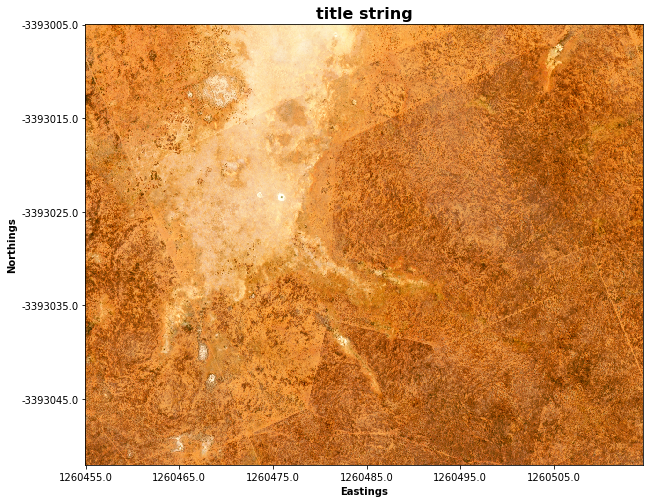

In [18]:
three_band_image_flat(Sentinal_gm, bands = ['red', 'green', 'blue'])

In [19]:
Sentinal_gm

<xarray.Dataset>
Dimensions:   (x: 1192, y: 941)
Coordinates:
  * y         (y) float64 -3.393e+06 -3.393e+06 -3.393e+06 -3.393e+06 ...
  * x         (x) float64 1.26e+06 1.26e+06 1.26e+06 1.26e+06 1.26e+06 ...
Data variables:
    red       (y, x) float64 1.603e+03 1.727e+03 1.871e+03 1.964e+03 ...
    blue      (y, x) float64 507.5 499.4 517.6 540.6 533.7 501.5 531.0 525.8 ...
    green     (y, x) float64 774.2 783.9 816.8 861.4 861.8 770.7 799.3 807.7 ...
    aerosol   (y, x) float64 499.9 497.0 495.3 495.2 494.8 488.2 477.4 477.9 ...
    rededge1  (y, x) float64 1.984e+03 1.984e+03 2.184e+03 2.184e+03 ...
    rededge2  (y, x) float64 2.23e+03 2.23e+03 2.417e+03 2.419e+03 2.259e+03 ...
    rededge3  (y, x) float64 2.294e+03 2.296e+03 2.467e+03 2.462e+03 ...
    nir1      (y, x) float64 2.399e+03 2.479e+03 2.56e+03 2.672e+03 ...
    nir2      (y, x) float64 2.46e+03 2.461e+03 2.589e+03 2.587e+03 ...
    swir1     (y, x) float64 3.927e+03 3.928e+03 4.079e+03 4.077e+03 ...
    swir2    

In [20]:
fc_data_gm

<xarray.Dataset>
Dimensions:  (x: 1192, y: 941)
Coordinates:
  * y        (y) float64 -3.393e+06 -3.393e+06 -3.393e+06 -3.393e+06 ...
  * x        (x) float64 1.26e+06 1.26e+06 1.26e+06 1.26e+06 1.26e+06 ...
Data variables:
    BS       (y, x) float64 47.54 52.14 52.14 48.7 48.7 48.7 41.65 41.65 ...
    PV       (y, x) float64 13.8 11.93 11.93 11.98 11.98 11.98 14.87 14.87 ...
    NPV      (y, x) float64 37.2 34.55 34.55 38.04 38.04 38.04 42.19 42.19 ...
    UE       (y, x) float64 9.218 8.392 8.392 9.258 9.258 9.258 9.398 9.398 ...
Attributes:
    crs:      EPSG:3577

In [21]:
trees_yep = fc_data_gm.where(fc_data_gm.BS<5)

In [22]:
trees_yep

<xarray.Dataset>
Dimensions:  (x: 1192, y: 941)
Coordinates:
  * y        (y) float64 -3.393e+06 -3.393e+06 -3.393e+06 -3.393e+06 ...
  * x        (x) float64 1.26e+06 1.26e+06 1.26e+06 1.26e+06 1.26e+06 ...
Data variables:
    BS       (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    PV       (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    NPV      (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    UE       (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577

In [23]:
#three_band_image_flat(trees_yep, bands = ['red', 'green', 'blue'], )

KeyError: 'red'

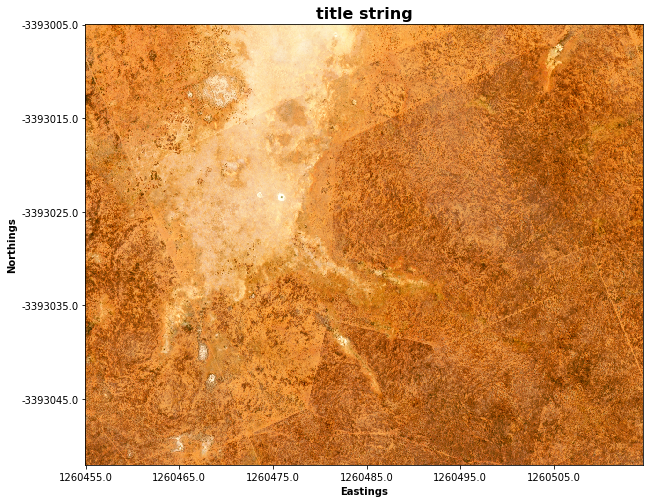

In [24]:
three_band_image_flat(Sentinal_gm, bands = ['red', 'green', 'blue'])

In [ ]:
rgb01 = fc_data_gm.to_array(dim='color').sel(color=[
    'BS','PV','NPV']).transpose('y', 'x', 'color')
rgb01 = rgb01.astype('double')
max_val01 = rgb01.max(['y', 'x'])
scaled01 = (rgb01 / max_val01)

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.imshow(scaled01)
#cbar = fig.colorbar(cax)
plt.show()

In [50]:
woody_yes = Sentinal_gm.where(fc_data_gm.BS<12)

#fc_data_gm.PV>=35
#green_not_trees = Sentinal_gm.where(100<tress_fc>120)
woody_no = Sentinal_gm.where(fc_data_gm.BS>=12)

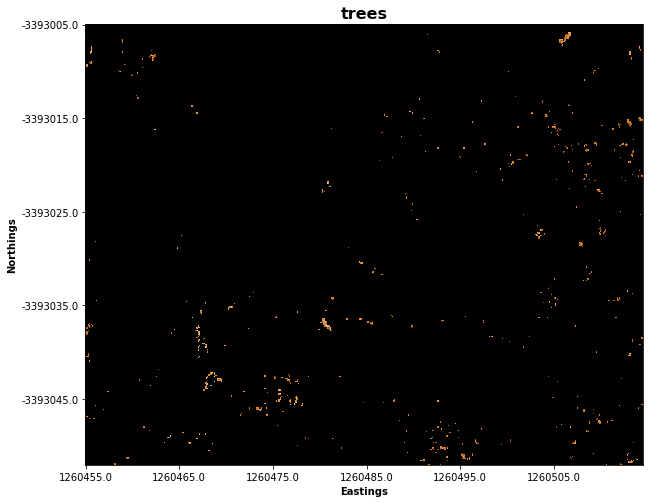

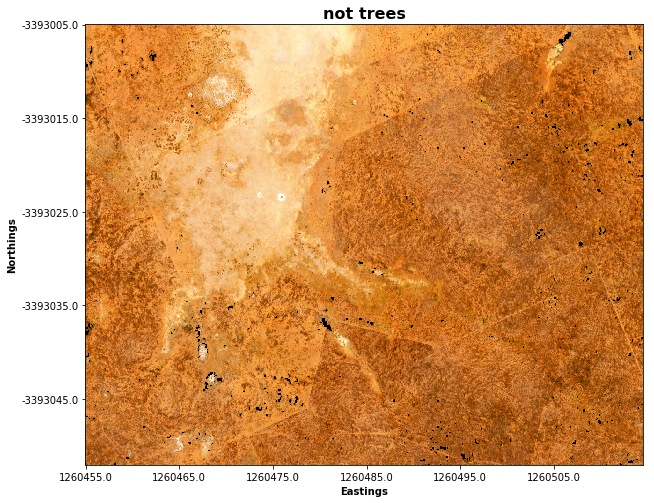

In [51]:
three_band_image_flat(woody_yes, bands = ['red', 'green', 'blue'], title_string='trees')
three_band_image_flat(woody_no, bands = ['red', 'green', 'blue'], title_string='not trees')

In [52]:

forrest_vals = {}

x = int(woody_yes.aerosol.mean())
forrest_vals[443] = x
x = int(woody_yes.blue.mean())
forrest_vals[490] =  x
x = int(woody_yes.green.mean())
forrest_vals[560] = x
x = int(woody_yes.red.mean())
forrest_vals[665] = x
x = int(woody_yes.rededge1.mean())
forrest_vals[705] = x
x = int(woody_yes.rededge2.mean())
forrest_vals[740] = x
x = int(woody_yes.rededge3.mean())
forrest_vals[783] = x
x = int(woody_yes.nir1.mean())
forrest_vals[842] = x
x = int(woody_yes.nir2.mean())
forrest_vals[865] = x
x = int(woody_yes.swir1.mean())
forrest_vals[1610] = x
x = int(woody_yes.swir2.mean())
forrest_vals[2190] = x


In [53]:
no_tree_vals = {}

x = int(woody_no.aerosol.mean())
no_tree_vals[443] = x
x = int(woody_no.blue.mean())
no_tree_vals[490] =  x
x = int(woody_no.green.mean())
no_tree_vals[560] = x
x = int(woody_no.red.mean())
no_tree_vals[665] = x
x = int(woody_no.rededge1.mean())
no_tree_vals[705] = x
x = int(woody_no.rededge2.mean())
no_tree_vals[740] = x
x = int(woody_no.rededge3.mean())
no_tree_vals[783] = x
x = int(woody_no.nir1.mean())
no_tree_vals[842] = x
x = int(woody_no.nir2.mean())
no_tree_vals[865] = x
x = int(woody_no.swir1.mean())
no_tree_vals[1610] = x
x = int(woody_no.swir2.mean())
no_tree_vals[2190] = x

In [54]:
no_tree_vals, forrest_vals


({443: 507,
  490: 481,
  560: 688,
  665: 1153,
  705: 1432,
  740: 1718,
  783: 1819,
  842: 1937,
  865: 2031,
  1610: 3125,
  2190: 2435},
 {443: 462,
  490: 419,
  560: 580,
  665: 837,
  705: 1156,
  740: 1653,
  783: 1811,
  842: 1956,
  865: 2053,
  1610: 2535,
  2190: 1788})

In [55]:
nice_list_non = [(v,k) for k,v in no_tree_vals.items()]
nice_list_trees = [(v,k) for k,v in forrest_vals.items()]

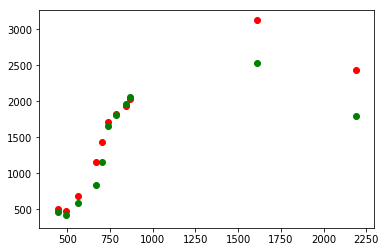

In [56]:
plt.scatter(*list(zip(*nice_list_non))[::-1], c = 'r' )
plt.scatter(*list(zip(*nice_list_trees))[::-1], c = 'g' )

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/numpy/core/numeric.py:583: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  return array(a, dtype, copy=False, order=order, subok=True)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/numpy/core/numeric.py:583: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  return array(a, dtype, copy=False, order=order, subok=True)


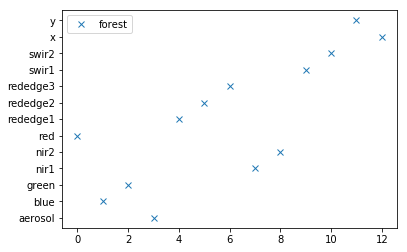

In [57]:
plt.plot(woody_yes,'x',label='forest')
plt.legend()
